In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')

## Helper methods

In [120]:
def get_test_ids(df, num_to_sample):
    labels = df.label_id.unique()
    list_of_test_id = random.sample(set(labels), num_to_sample)
    return list_of_test_id

### Load data

In [2]:
from dataset_generator import TimeWindowDatasetGenerator
twg = TimeWindowDatasetGenerator()
df = twg.get_labelled_timewindow_dataframe(
    exclude_after_notification=True, 
    label_feature="context", 
    time_window=10)

In [3]:
session_df = pd.read_csv('task/SessionData-all.csv')
session_df.head()

,id,duration,watchId,age,gender,fairNumber
0,1,8021351,0Q3V,18-25,female,1
1,2,3752526,0Q3V,26-30,male,1
2,3,3989497,0QED,18-25,male,1
3,4,4979198,0QED,18-25,male,1
4,5,4836199,0QVM,18-25,male,1


### Data pre-processing and cleaning

In [4]:

non_feat_columns = ["ppgValue", "notification", "engagement", "hrStatus","ibiStatus", "affect", "context","duration","id"]
df.loc[df['hrStatus'] != 1, 'hr'] = np.nan #| 1 | Successful heart rate measurement. |(the rest is trash)
df.loc[df['ibiStatus'] == 1, 'hrIbi'] = np.nan # | Status flag for Ibi -> 1: bad; 0: good. |
df = pd.merge(left=df, right=session_df, left_on="sessionId", right_on="id")
df = df.drop(columns=non_feat_columns)
df["sessionId_key"]= df["sessionId"]
df["label_id_key"]= df["label_id"]
df = df.groupby(["sessionId_key", "label_id_key"]).ffill().bfill() #fill missing data (backfill as the last step to get the first few rows)
df.head()

,sessionId,timestamp,x,y,z,hr,hrIbi,label_id,label,watchId,age,gender,fairNumber
0,1,481283,978.0,1674.0,3632.0,99.0,1003.0,1,WALKING,0Q3V,18-25,female,1
1,1,481323,943.0,1717.0,3660.0,99.0,1003.0,1,WALKING,0Q3V,18-25,female,1
2,1,481363,1018.0,1610.0,3818.0,99.0,1003.0,1,WALKING,0Q3V,18-25,female,1
3,1,481403,898.0,1538.0,3733.0,99.0,1003.0,1,WALKING,0Q3V,18-25,female,1
4,1,481444,1028.0,1579.0,3852.0,99.0,1003.0,1,WALKING,0Q3V,18-25,female,1


In [39]:
df.describe()

,sessionId,timestamp,x,y,z,hr,hrIbi,label_id,fairNumber
count,723454.00000,7.234540e+05,723454.000000,723454.000000,723454.000000,720351.000000,723454.000000,723454.000000,723454.000000
mean,34.35866,3.397225e+06,-743.232558,-2322.430655,822.518286,84.637500,791.339553,116.994963,3.162939
std,15.96099,2.389836e+06,2152.326025,1417.513938,2023.766269,10.346834,556.193758,67.265302,1.072277
min,1.00000,1.110350e+05,-27834.000000,-28220.000000,-23258.000000,55.000000,0.000000,1.000000,1.000000
25%,24.00000,1.568070e+06,-2643.000000,-3445.000000,-309.000000,77.000000,398.000000,59.000000,3.000000
50%,38.00000,3.097798e+06,-410.000000,-2507.000000,778.000000,84.000000,611.000000,117.000000,4.000000
75%,46.00000,5.036644e+06,707.000000,-1400.000000,2401.000000,91.000000,991.000000,175.000000,4.000000
max,58.00000,9.170759e+06,20054.000000,32530.000000,32651.000000,121.000000,2434.000000,233.000000,4.000000


<AxesSubplot:xlabel='label', ylabel='count'>

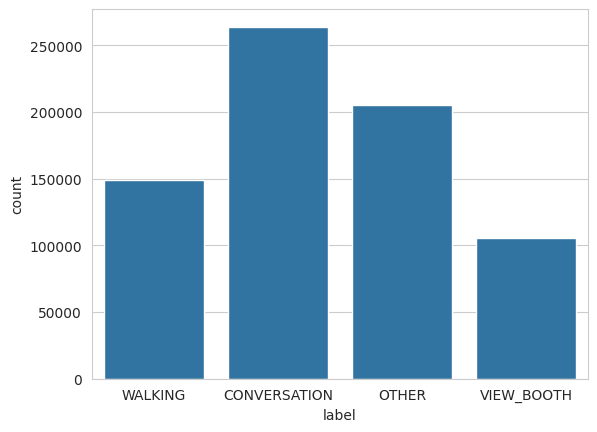

In [42]:
sns.set_style("whitegrid")
sns.countplot(x = "label", data = df)

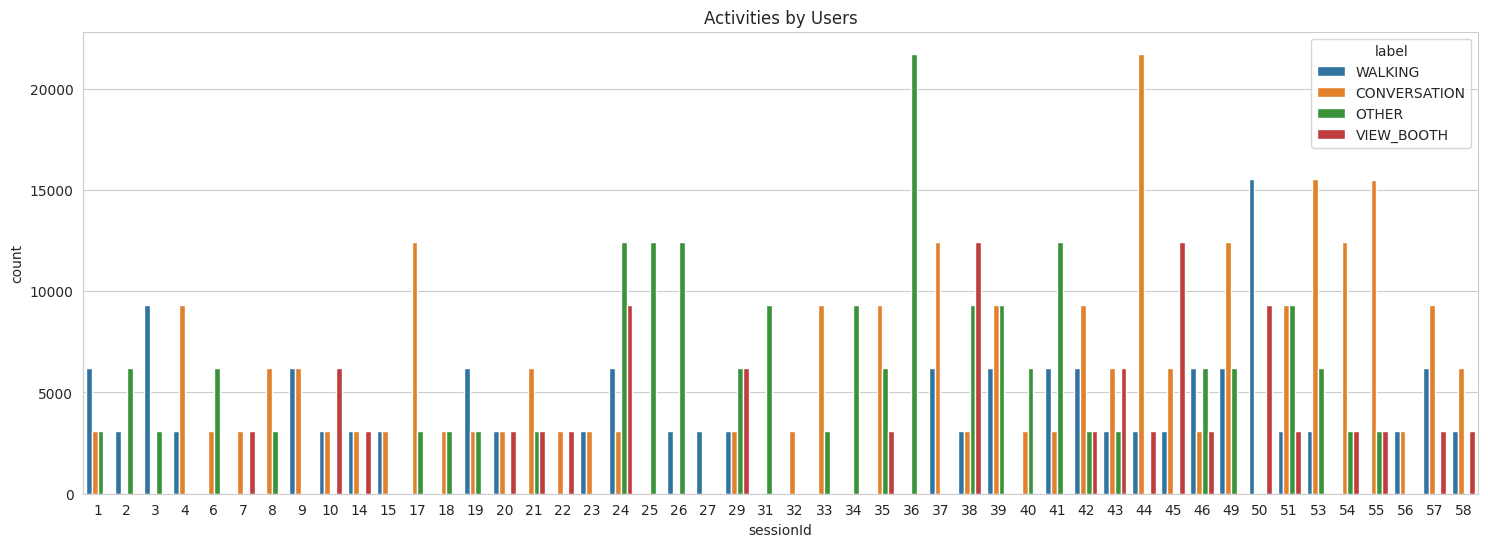

In [43]:
plt.figure(figsize = (18, 6))
sns.countplot(x = "sessionId", hue = "label", data = df)
plt.title("Activities by Users")
plt.show()

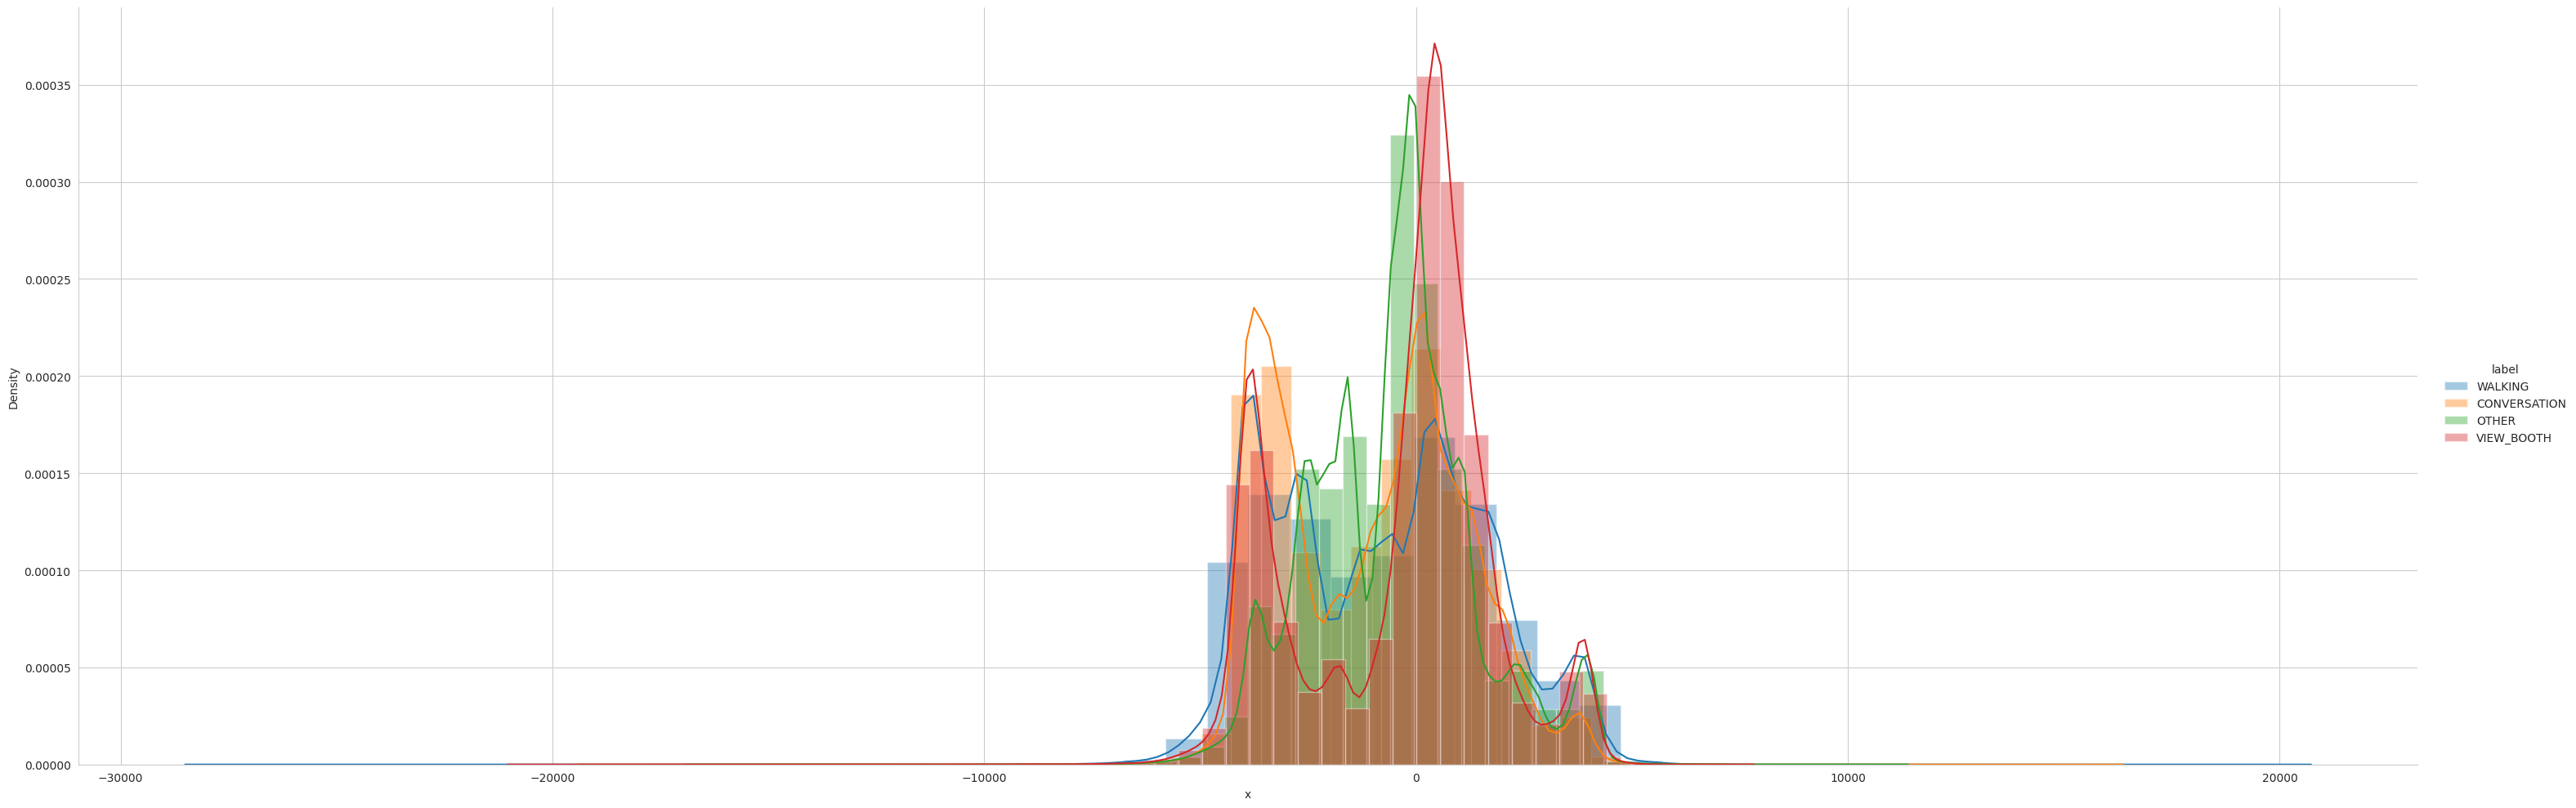

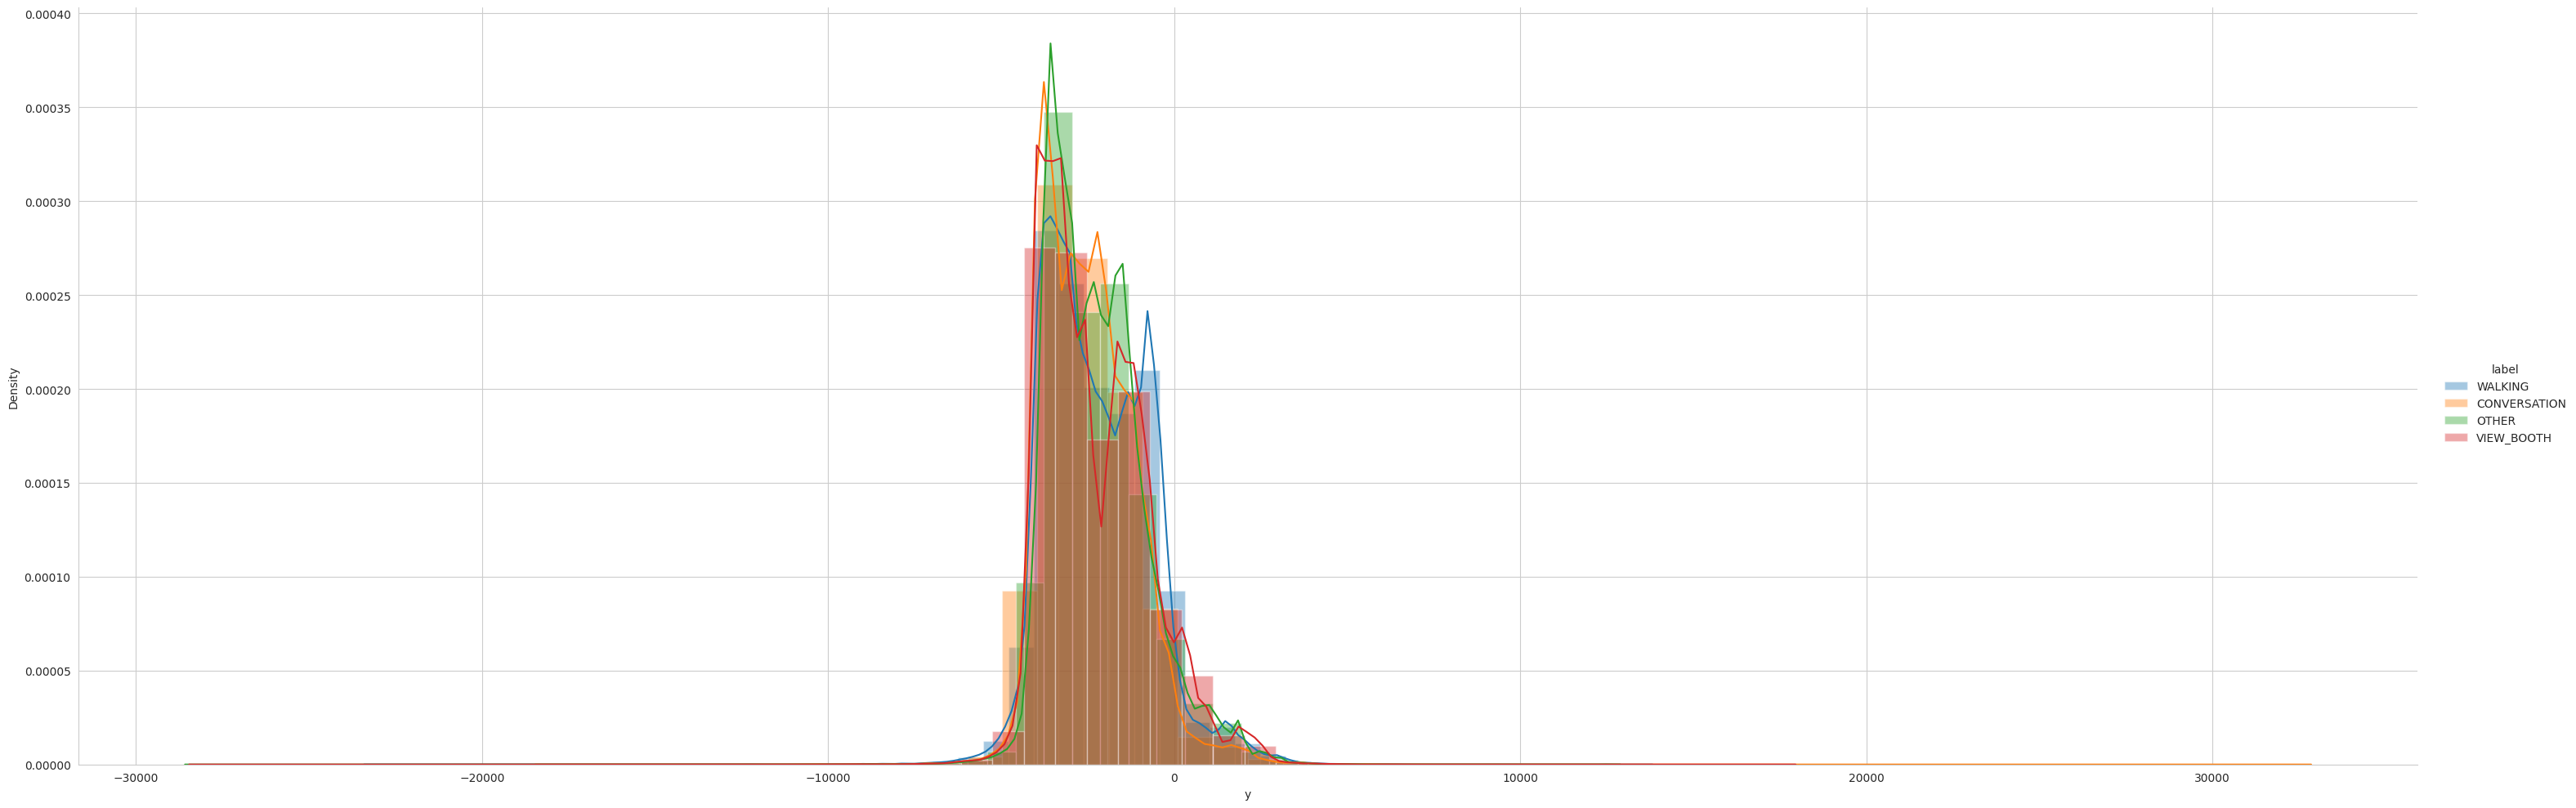

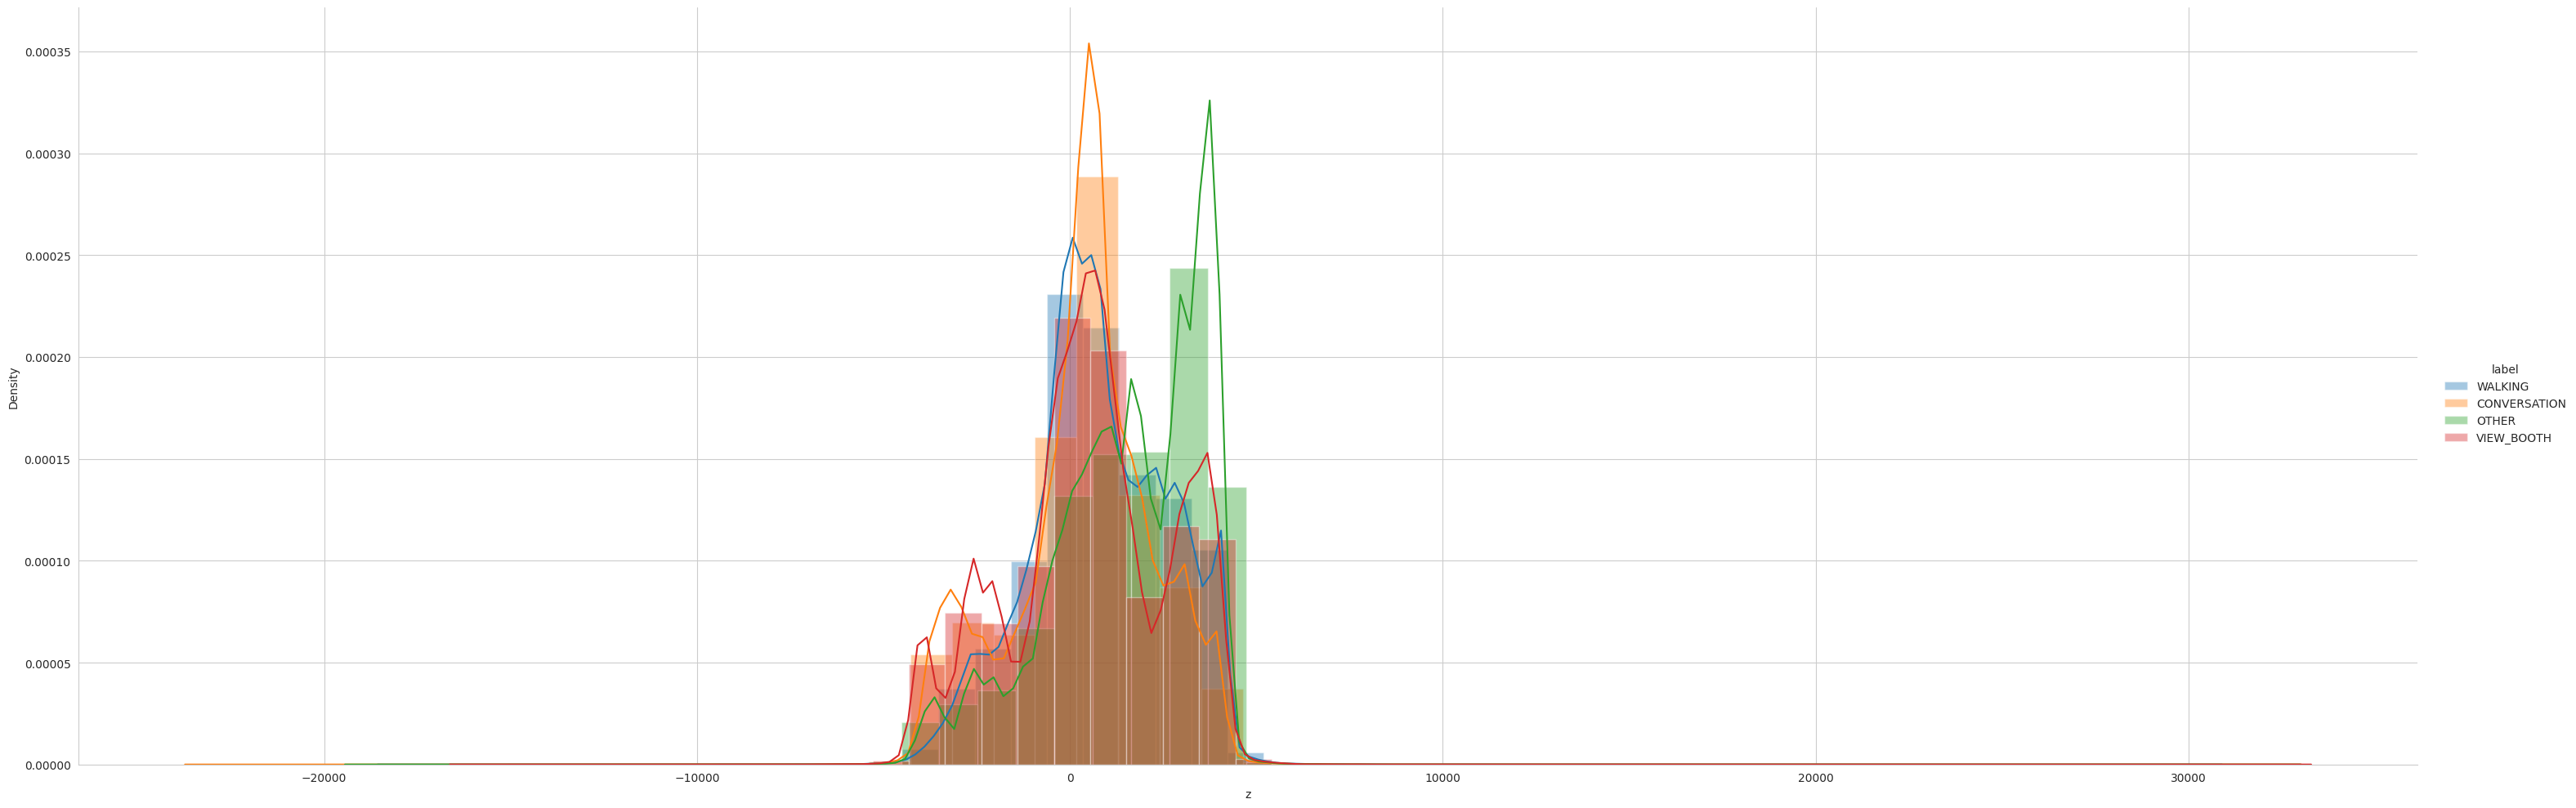

In [54]:
sns.FacetGrid(df, hue = "label", height=10, aspect=3).map(sns.distplot, "x").add_legend()
sns.FacetGrid(df, hue = "label", height=10,aspect=3).map(sns.distplot, "y").add_legend()
sns.FacetGrid(df, hue = "label", height=10, aspect=3).map(sns.distplot, "z").add_legend()


In [69]:
test_ids = get_test_ids(df, 30)
df_train = df[~df["label_id"].isin(test_ids)]
df_test = df[df["label_id"].isin(test_ids)]

In [70]:
df_test

,sessionId,timestamp,x,y,z,hr,hrIbi,label_id,label,watchId,age,gender,fairNumber
21724,3,111035,-586.0,-2315.0,3326.0,66.0,923.0,8,OTHER,0QED,18-25,male,1
21725,3,111076,-629.0,-2271.0,3371.0,66.0,923.0,8,OTHER,0QED,18-25,male,1
21726,3,111115,-618.0,-2293.0,3355.0,66.0,923.0,8,OTHER,0QED,18-25,male,1
21727,3,111155,-602.0,-2297.0,3314.0,66.0,923.0,8,OTHER,0QED,18-25,male,1
21728,3,111196,-602.0,-2325.0,3332.0,66.0,923.0,8,OTHER,0QED,18-25,male,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
714136,58,455748,1185.0,202.0,3889.0,79.0,1601.0,230,CONVERSATION,PVQB,18-25,female,4
714137,58,455788,1222.0,221.0,3909.0,79.0,1601.0,230,CONVERSATION,PVQB,18-25,female,4
714138,58,455828,1225.0,219.0,3947.0,79.0,1601.0,230,CONVERSATION,PVQB,18-25,female,4
714139,58,455869,1180.0,210.0,3903.0,79.0,1601.0,230,CONVERSATION,PVQB,18-25,female,4


In [14]:

# Define aggregation functions
agg_funcs = {
    'z': ['mean', 'median', 'min','var', "std", "max"],
    'hr': ['mean', 'median', 'min','var', "std", "max"],
    'hrIbi': ['mean', 'median', 'min','var', "std", "max"],
    'watchId': 'first',
    'age': 'first',
    'gender': 'first',
    'fairNumber': 'first',
    'label': 'first'
}

# Group by 'label_id' and apply aggregation functions
grouped_df = df.groupby('label_id').agg(agg_funcs)
grouped_df.columns = grouped_df.columns.to_flat_index().str.join('_')
categorical_cols = ['watchId_first',
    'age_first',
    'gender_first',
    'label_first']
for cat_col in categorical_cols:
    grouped_df[cat_col.split("_")[0]] = pd.Categorical(grouped_df[cat_col]).codes
grouped_df= grouped_df.drop(columns=categorical_cols).dropna()


In [15]:
grouped_df

,z_mean,z_median,z_min,z_var,z_std,z_max,hr_mean,hr_median,hr_min,hr_var,...,hrIbi_median,hrIbi_min,hrIbi_var,hrIbi_std,hrIbi_max,fairNumber_first,watchId,age,gender,label
label_id,,,,,,,,,,,,,,,,,,,,,
1,3933.735632,3933.0,3572.0,2.209516e+04,148.644397,4556.0,98.237548,98.0,97.0,0.251046,...,1003.0,1003.0,0.000000,0.000000,1003.0,1,0,0,0,3
2,1210.747126,802.0,-5310.0,2.105758e+06,1451.122853,7478.0,77.501916,78.0,76.0,0.650958,...,1003.0,1003.0,0.000000,0.000000,1003.0,1,0,0,0,0
3,2145.484615,2145.5,1976.0,1.504158e+03,38.783477,2274.0,81.919231,82.0,81.0,0.074532,...,825.0,770.0,4192.783546,64.751707,1003.0,1,0,0,0,1
4,-1124.131274,-1232.0,-3846.0,1.208809e+06,1099.458714,4315.0,120.000000,120.0,120.0,0.000000,...,614.0,551.0,39369.762623,198.418151,1203.0,1,0,0,0,3
5,869.237548,416.0,-6275.0,4.583421e+06,2140.892615,5802.0,120.524904,121.0,120.0,0.250339,...,695.0,695.0,21602.494106,146.977869,1080.0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,1790.536398,1374.0,470.0,7.956238e+05,891.977494,3391.0,85.298851,85.0,84.0,0.418037,...,2040.0,346.0,591499.233687,769.089874,2040.0,4,13,1,0,0
229,241.796935,2549.0,-4465.0,9.527326e+06,3086.636700,3583.0,80.000000,80.0,80.0,0.000000,...,403.0,332.0,605363.753316,778.051254,2040.0,4,13,1,0,3
230,740.854406,325.0,-4502.0,1.917302e+06,1384.666736,4544.0,79.666667,80.0,79.0,0.223077,...,390.0,390.0,457470.250928,676.365471,2040.0,4,13,0,0,0


In [144]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have your DataFrame 'grouped_df' prepared
# Convert label column to numeric if necessary
# Define features (X) and target variable (y)
X = grouped_df.drop(columns=['label'])
y = grouped_df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predictions on the testing set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5531914893617021


In [145]:
from multiclass_evaluation import MulticlassPrecisionRecall
mpr = MulticlassPrecisionRecall()
mpr.get_multiclass_evaluation(y_test, y_pred)

,0,1,2,3
precision,0.619048,0.666667,0.500000,0.4
recall,0.722222,0.500000,0.142857,0.6
true_positive,13.000000,6.000000,1.000000,6.0
false_positive,8.000000,3.000000,1.000000,9.0
false_negative,5.000000,6.000000,6.000000,4.0


In [146]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
logreg = LogisticRegression(max_iter=1000)  # You may need to adjust max_iter depending on convergence
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.425531914893617
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.72      0.57        18
           1       0.56      0.42      0.48        12
           2       0.00      0.00      0.00         7
           3       0.20      0.20      0.20        10

    accuracy                           0.43        47
   macro avg       0.30      0.33      0.31        47
weighted avg       0.36      0.43      0.38        47

Confusion Matrix:
[[13  1  0  4]
 [ 6  5  0  1]
 [ 2  2  0  3]
 [ 7  1  0  2]]


In [138]:
X_train.dropna()

,x_std,y_std,z_mean,z_median,z_var,z_std,hr_std,hr_max,hrIbi_std,hrIbi_max,fairNumber_first,watchId,age,gender
label_id,,,,,,,,,,,,,,
145,737.932316,618.712095,2062.544061,2014.0,2.812895e+05,530.367350,0.000000,85.0,160.462778,935.0,4,4,0,1
70,121.527753,52.737587,-657.881226,-643.0,6.640061e+04,257.683164,0.654194,63.0,726.334814,2040.0,3,2,0,0
231,334.775923,508.009452,-868.521073,-843.0,1.191905e+05,345.239756,0.439771,89.0,439.637798,1559.0,4,13,0,0
197,1245.341414,2163.844422,1710.312741,2474.0,5.411162e+06,2326.190441,0.473442,83.0,313.902484,1206.0,4,9,1,1
224,2127.071419,999.725582,1942.426923,1758.0,1.208849e+06,1099.476579,0.000000,79.0,578.748828,2040.0,4,13,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,292.281425,1281.781672,3069.796154,2996.5,2.700564e+05,519.669527,1.534651,79.0,0.000000,657.0,3,13,0,1
15,738.054910,2301.141658,2118.400000,1973.5,3.260946e+06,1805.808860,1.060089,90.0,187.073833,1133.0,1,1,0,1
93,1170.261821,922.142621,112.667954,-518.0,1.648203e+06,1283.823407,1.225972,72.0,74.658476,990.0,3,12,2,0


In [18]:
grouped_df.columns

Index(['z_mean', 'z_median', 'z_min', 'z_var', 'z_std', 'z_max', 'hr_mean',
       'hr_median', 'hr_min', 'hr_var', 'hr_std', 'hr_max', 'hrIbi_mean',
       'hrIbi_median', 'hrIbi_min', 'hrIbi_var', 'hrIbi_std', 'hrIbi_max',
       'fairNumber_first', 'watchId', 'age', 'gender', 'label'],
      dtype='object')

In [22]:
fair1= grouped_df[(grouped_df.watchId<8)&(grouped_df.fairNumber_first==1)]

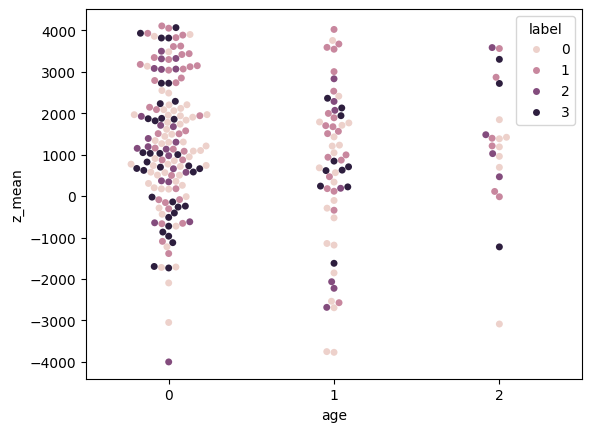

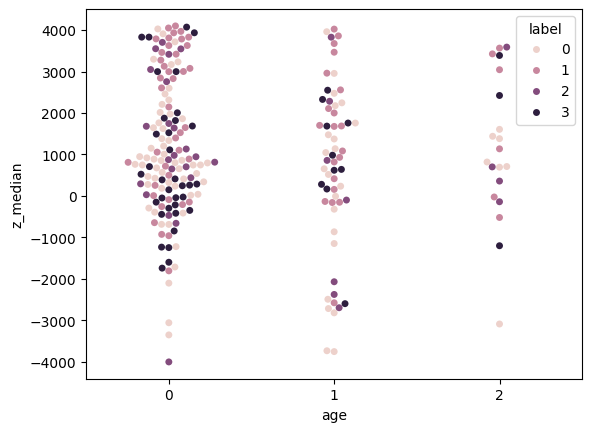

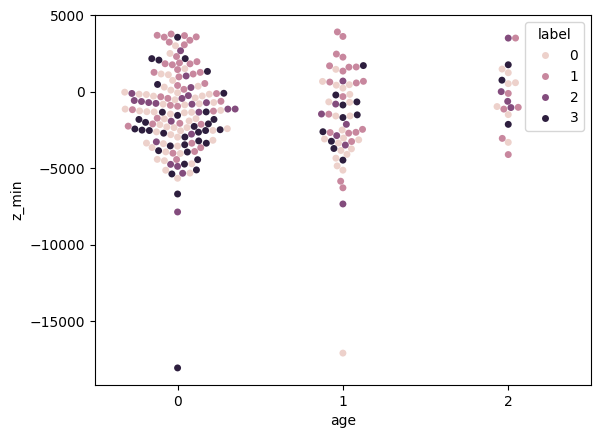

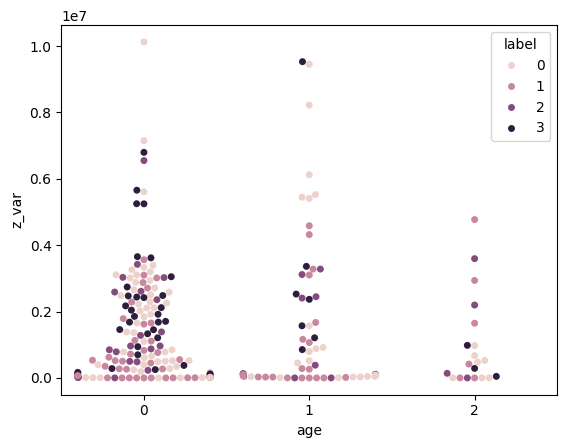

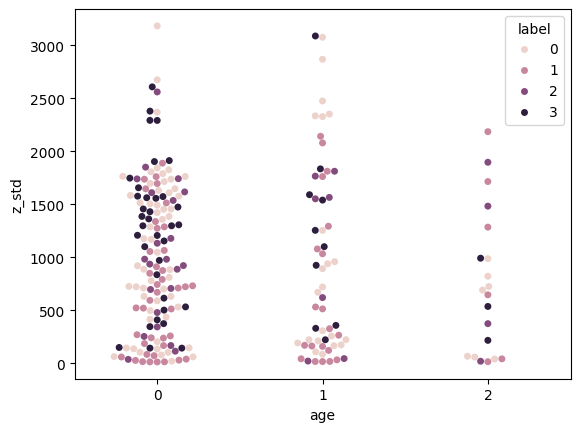

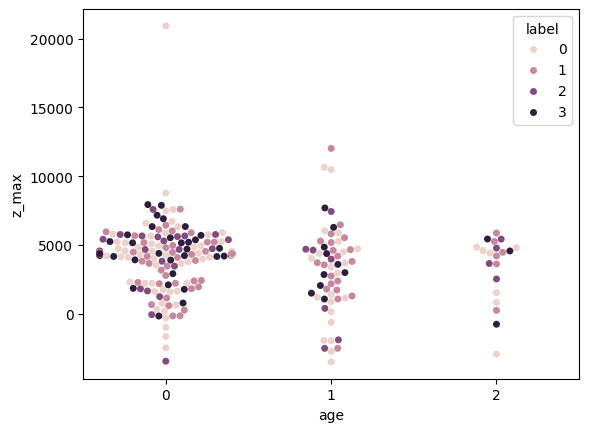

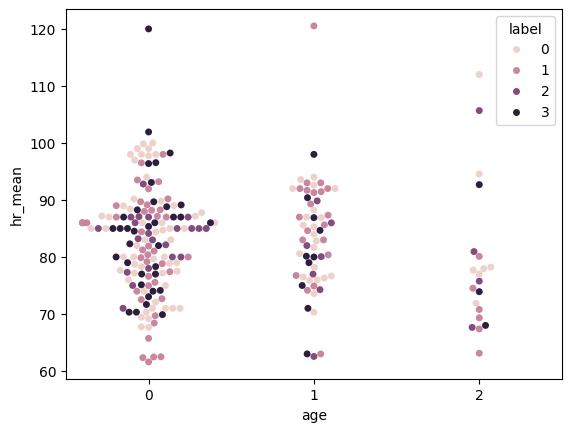

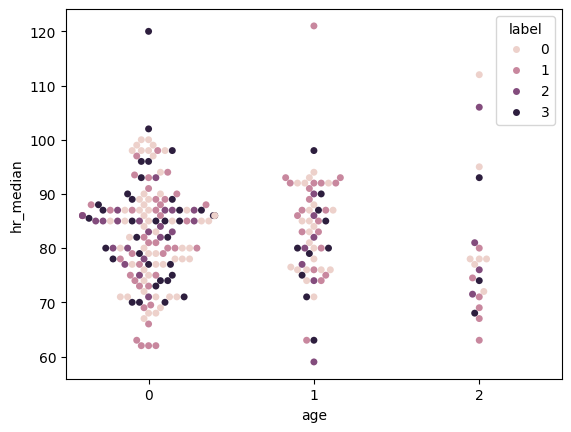

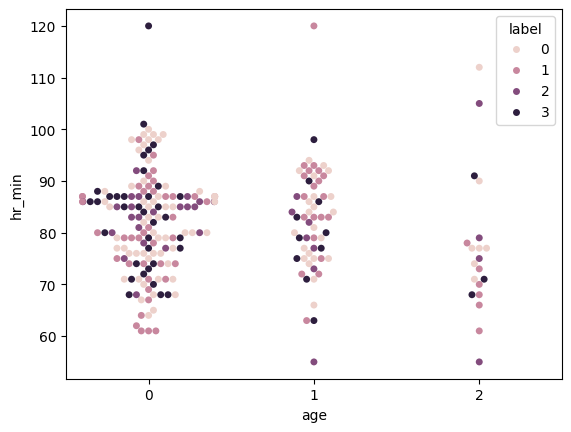

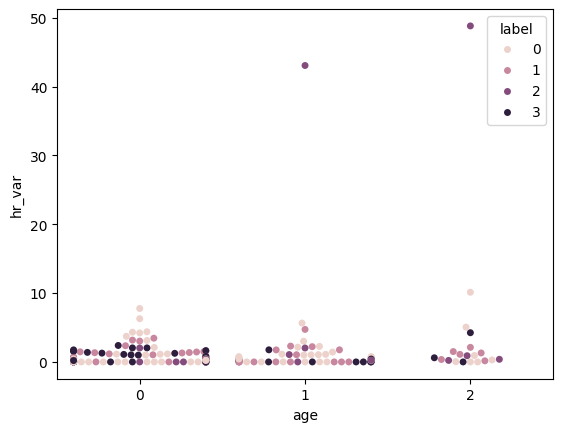

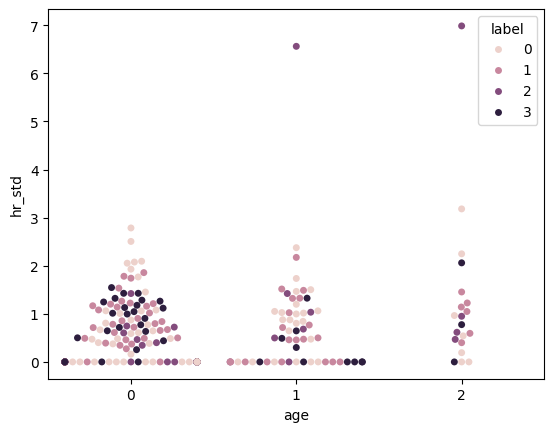

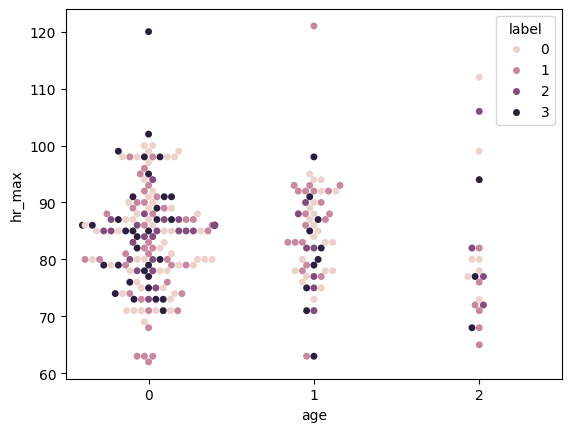

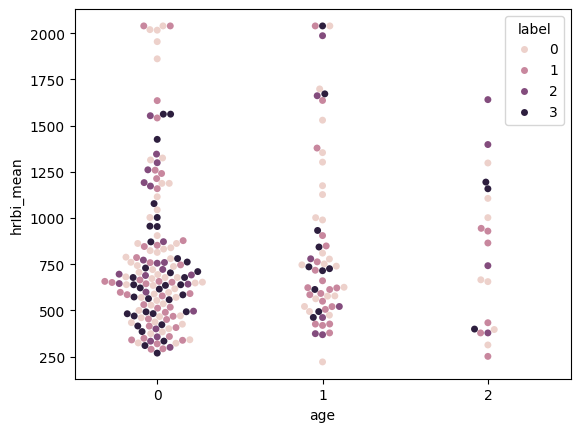

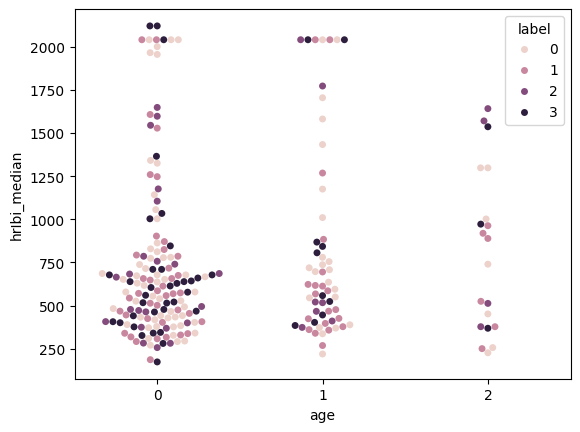

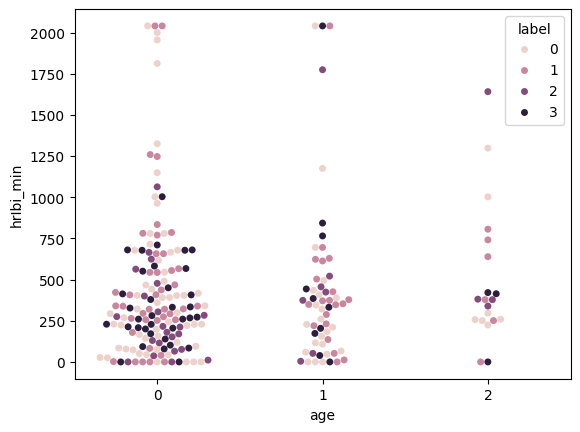

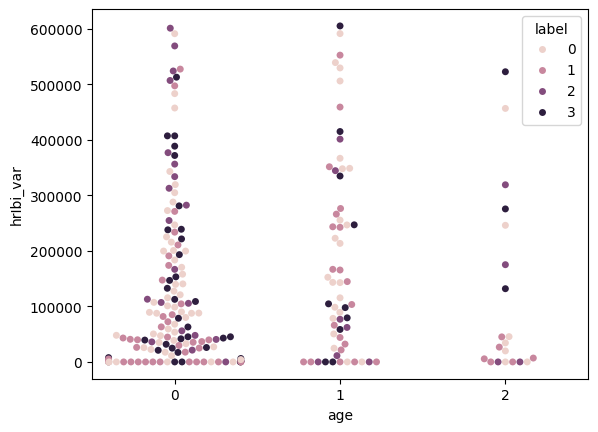

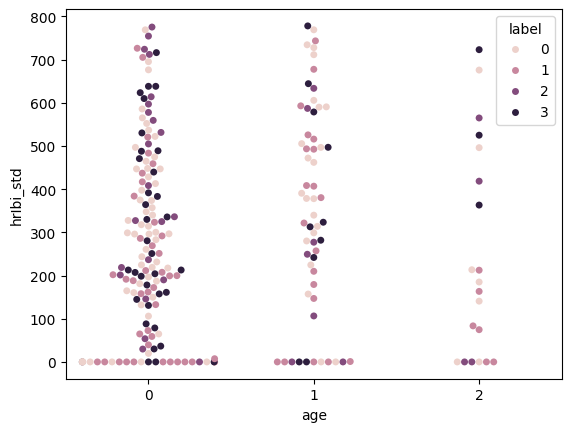

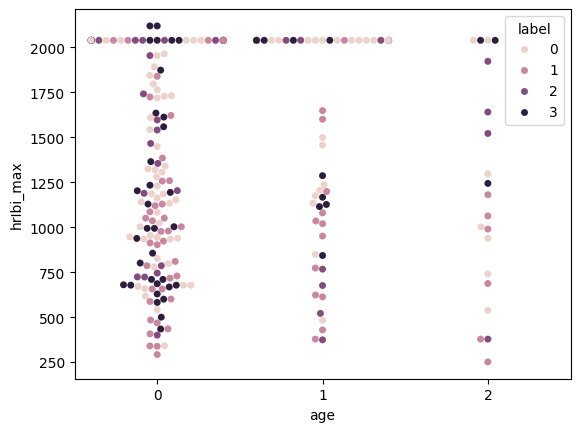

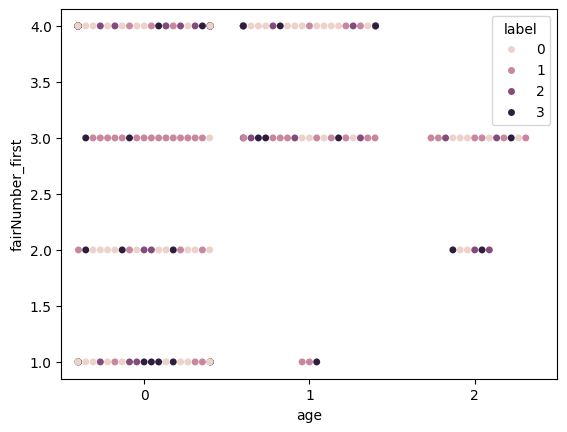

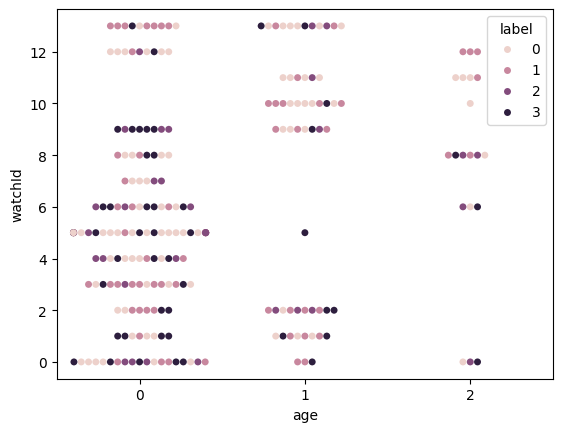

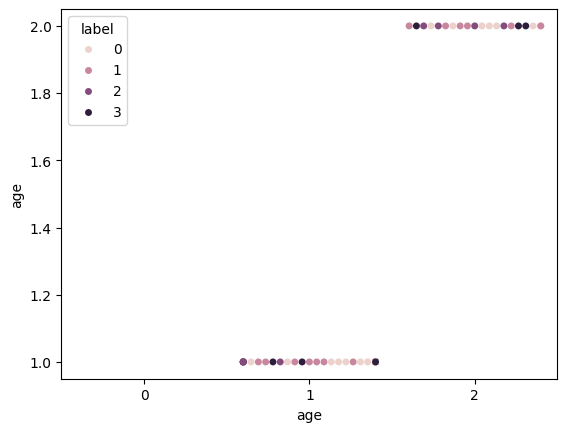

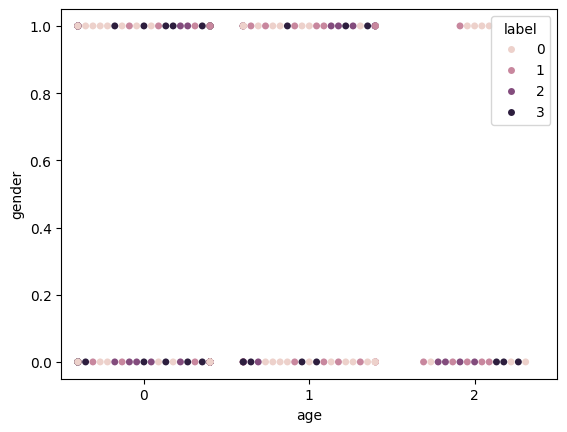

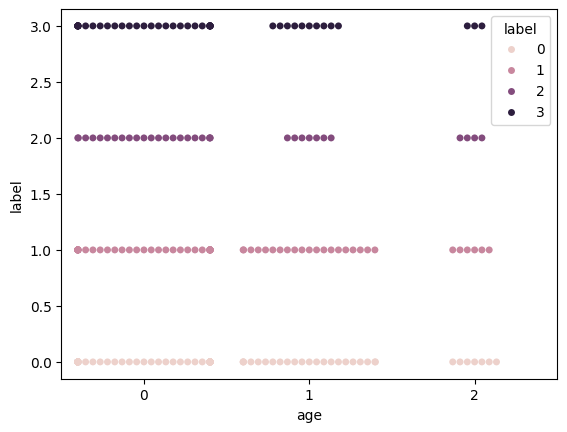

In [30]:
for col in grouped_df.columns:
    sns.swarmplot(data=grouped_df, x="age", y=col,hue="label")
    plt.show()